In [1]:
import os
import random
import numpy as np
import pickle
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Reproducibilidad

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)


In [3]:
# Cargar histórico procesado

with open('dfe_guardado.pkl', 'rb') as e:
    dfe = pickle.load(e)

dfa = dfe.copy()


In [4]:
dfa = dfa.drop(['goles_local', 'goles_visitante'], axis=1)

In [5]:
dfa.head(3000)

,torneo,semestre,ronda,fecha_torneo,equipo_local,equipo_visitante,resultado
0,2021,1,INICIAL,1,millonarios,envigado,LOCAL
1,2021,1,INICIAL,1,junior,medellin,LOCAL
2,2021,1,INICIAL,1,pasto,equidad,EMPATE
3,2021,1,INICIAL,1,nacional,santa fe,LOCAL
4,2021,1,INICIAL,1,cali,jaguares,LOCAL
...,...,...,...,...,...,...,...
2188,2025,2,CUADRANGULARES,1,medellin,america,EMPATE
2189,2025,2,CUADRANGULARES,1,fortaleza,santa fe,VISITANTE
2190,2025,2,CUADRANGULARES,1,bucaramanga,tolima,EMPATE
2191,2025,2,CUADRANGULARES,1,nacional,medellin,LOCAL


In [6]:
def agregar_rachas(dfa):
    dfa = dfa.copy()
    dfa["racha_local_5"] = 0
    dfa["racha_visitante_5"] = 0

    historial = {}  # { equipo: [puntos acumulados] }

    for idx, row in dfa.iterrows():
        local = row["equipo_local"]
        visitante = row["equipo_visitante"]
        resultado = row["resultado"]

        # Inicializar historial si no existe
        if local not in historial:
            historial[local] = []
        if visitante not in historial:
            historial[visitante] = []

        # Registrar racha previa (últimos 5 partidos)
        dfa.at[idx, "racha_local_5"] = sum(historial[local][-5:])
        dfa.at[idx, "racha_visitante_5"] = sum(historial[visitante][-5:])

        # Calcular puntos del partido actual
        puntos_local = 1 if resultado == "EMPATE" else (3 if resultado == "LOCAL" else 0)
        puntos_visitante = 1 if resultado == "EMPATE" else (3 if resultado == "VISITANTE" else 0)

        # Actualizar historial
        historial[local].append(puntos_local)
        historial[visitante].append(puntos_visitante)

    return dfa


In [7]:
def agregar_duelos_directos(dfa):
    dfa = dfa.copy()

    dfa["duelos_directos_local"] = 0
    dfa["duelos_directos_visitante"] = 0

    duelos = {}  # {(equipo1, equipo2): {"local": [], "visitante": []}}

    for idx, row in dfa.iterrows():

        local = row["equipo_local"]
        visitante = row["equipo_visitante"]
        resultado = row["resultado"]

        # Clave ordenada para que (A,B) y (B,A) sean el mismo duelo histórico
        key = tuple(sorted([local, visitante]))

        if key not in duelos:
            duelos[key] = {"local": [], "visitante": []}

        # Registrar racha previa de duelos directos
        dfa.at[idx, "duelos_directos_local"] = sum(duelos[key]["local"][-5:])
        dfa.at[idx, "duelos_directos_visitante"] = sum(duelos[key]["visitante"][-5:])

        # Actualizar historial según resultado del partido actual
        if resultado == "EMPATE":
            duelos[key]["local"].append(1)
            duelos[key]["visitante"].append(1)

        elif resultado == "LOCAL":
            duelos[key]["local"].append(3)
            duelos[key]["visitante"].append(0)

        elif resultado == "VISITANTE":
            duelos[key]["local"].append(0)
            duelos[key]["visitante"].append(3)

    return dfa


In [8]:
# aplicar ingeniería
dfa = agregar_rachas(dfa)
dfa = agregar_duelos_directos(dfa)

In [9]:
# Selección de variables

X = dfa[[
    "equipo_local",
    "equipo_visitante",
    "racha_local_5",
    "racha_visitante_5",
    "duelos_directos_local",
    "duelos_directos_visitante"
]]

y = dfa["resultado"]



In [10]:
dfa.head(3000)

,torneo,semestre,ronda,fecha_torneo,equipo_local,equipo_visitante,resultado,racha_local_5,racha_visitante_5,duelos_directos_local,duelos_directos_visitante
0,2021,1,INICIAL,1,millonarios,envigado,LOCAL,0,0,0,0
1,2021,1,INICIAL,1,junior,medellin,LOCAL,0,0,0,0
2,2021,1,INICIAL,1,pasto,equidad,EMPATE,0,0,0,0
3,2021,1,INICIAL,1,nacional,santa fe,LOCAL,0,0,0,0
4,2021,1,INICIAL,1,cali,jaguares,LOCAL,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2188,2025,2,CUADRANGULARES,1,medellin,america,EMPATE,7,7,11,2
2189,2025,2,CUADRANGULARES,1,fortaleza,santa fe,VISITANTE,3,6,12,3
2190,2025,2,CUADRANGULARES,1,bucaramanga,tolima,EMPATE,7,13,8,5
2191,2025,2,CUADRANGULARES,1,nacional,medellin,LOCAL,5,5,7,4


In [11]:
categorical_features = ["equipo_local", "equipo_visitante"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ],
    remainder="passthrough"
)


In [12]:
# Pipeline de preprocesamiento + modelo

categorical_features = ["equipo_local", "equipo_visitante"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ],
    remainder="passthrough"
)

model = RandomForestClassifier(
    n_estimators=150,
    max_depth=6,
    min_samples_split=6,
    min_samples_leaf=3,
    max_features="sqrt",
    class_weight="balanced",
    random_state=42
)

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", model)
])

In [13]:
# VALIDACIÓN CRUZADA K-FOLD (10 folds)

print("\n===== VALIDACIÓN CRUZADA 10-Fold =====")
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(pipeline, X, y, cv=kfold, scoring='accuracy')

print("Scores por fold:", scores)
print("Promedio:", scores.mean())
print("Desviación estándar:", scores.std())


===== VALIDACIÓN CRUZADA 10-Fold =====
Scores por fold: [0.40774487 0.40546697 0.4191344  0.41324201 0.45205479]
Promedio: 0.4195286090221654
Desviación estándar: 0.016936443311335623


In [14]:
# Entrenamiento final con train/test

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

pipeline.fit(X_train, y_train)

print("\nScore de test:", pipeline.score(X_test, y_test))

# predicciones
y_pred = pipeline.predict(X_test)


Score de test: 0.3843351548269581


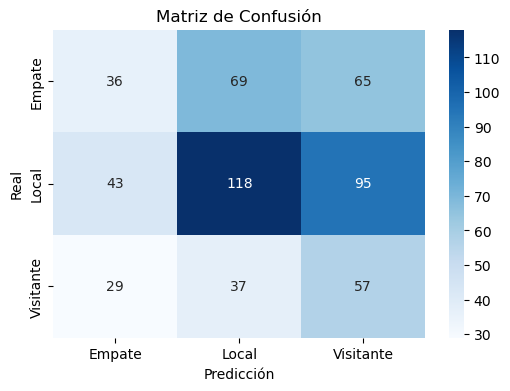

In [15]:
# Matriz de confusión

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Empate", "Local", "Visitante"],
            yticklabels=["Empate", "Local", "Visitante"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


In [16]:
# Reporte de desempeño

print(classification_report(
    y_test, y_pred,
    target_names=["Empate", "Local", "Visitante"]
))

              precision    recall  f1-score   support

      Empate       0.33      0.21      0.26       170
       Local       0.53      0.46      0.49       256
   Visitante       0.26      0.46      0.34       123

    accuracy                           0.38       549
   macro avg       0.37      0.38      0.36       549
weighted avg       0.41      0.38      0.38       549



In [17]:
# FUNCIONES DE PREDICCIÓN

def preparar_partido(df_hist, equipo_local, equipo_visitante):
    df_temp = agregar_rachas(df_hist.copy())
    df_temp = agregar_duelos_directos(df_temp)

    rec_local = df_temp[df_temp["equipo_local"] == equipo_local]["racha_local_5"]
    rec_visit = df_temp[df_temp["equipo_visitante"] == equipo_visitante]["racha_visitante_5"]

    racha_local = rec_local.iloc[-1] if len(rec_local) > 0 else 0
    racha_visitante = rec_visit.iloc[-1] if len(rec_visit) > 0 else 0

    mask = (
        (df_temp["equipo_local"] == equipo_local) & (df_temp["equipo_visitante"] == equipo_visitante)
    ) | (
        (df_temp["equipo_local"] == equipo_visitante) & (df_temp["equipo_visitante"] == equipo_local)
    )

    if mask.any():
        duelos_local = df_temp[mask]["duelos_directos_local"].iloc[-1]
        duelos_visitante = df_temp[mask]["duelos_directos_visitante"].iloc[-1]
    else:
        duelos_local = 0
        duelos_visitante = 0

    nuevo = pd.DataFrame([{
        "equipo_local": equipo_local,
        "equipo_visitante": equipo_visitante,
        "racha_local_5": racha_local,
        "racha_visitante_5": racha_visitante,
        "duelos_directos_local": duelos_local,
        "duelos_directos_visitante": duelos_visitante
    }])

    return nuevo


def predecir_partido(df_hist, pipeline, equipo_local, equipo_visitante):
    entrada = preparar_partido(df_hist, equipo_local, equipo_visitante)
    proba = pipeline.predict_proba(entrada)[0]
    clases = pipeline.classes_

    return {clases[i]: round(proba[i] * 100, 2) for i in range(3)}


In [18]:
pred = predecir_partido(
    df_hist=dfa,
    pipeline=pipeline,
    equipo_local="tolima",
    equipo_visitante="junior"
)

print(pred)
df_pred = pd.DataFrame.from_dict(pred, orient='index', columns=['Probabilidad'])
print("\n Resultado mas Probable:")
display(df_pred.sort_values(by='Probabilidad', ascending=False))

{'EMPATE': np.float64(35.8), 'LOCAL': np.float64(35.17), 'VISITANTE': np.float64(29.03)}

 Resultado mas Probable:


,Probabilidad
EMPATE,35.80
LOCAL,35.17
VISITANTE,29.03


In [19]:
y.value_counts()
y.value_counts(normalize=True)*100

resultado
LOCAL        45.782034
EMPATE       29.958960
VISITANTE    24.259006
Name: proportion, dtype: float64